In [1]:
import numpy as np
import pandas as pd
import requests
import plotly.express as px
pd.set_option("display.max_columns", None)
import osmnx as ox
import networkx as nx
from itertools import combinations
from itertools import combinations

In [2]:
df = pd.read_csv("coordinates.csv")
df.head()

,Latitude,Longitude,Filename
0,-43.746,173.122,Hourly_Le_Bons_Bay_NZLBX_43.746S_173.122E_236m...
1,-37.671,176.197,Hourly_Tauranga_Aerodrome_NZTGA_37.671S_176.19...
2,-50.493,166.296,Hourly_Enderby_Island_NZEDX_50.493S_166.296E_3...
3,-41.727,174.276,Hourly_Cape_Campbell_NZCCX_41.727S_174.276E_5m...
4,-36.832,175.675,Hourly_Whitianga_Aerodrome_NZWTA_36.832S_175.6...


In [3]:
df["station_name"] = ["_".join(filename.split("_")[1:3]) for filename in df.Filename]

In [4]:
#df["used"] = True
#df[df["station_name" ]]["used"]

/tmp/ipykernel_2580809/934882331.py:6: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


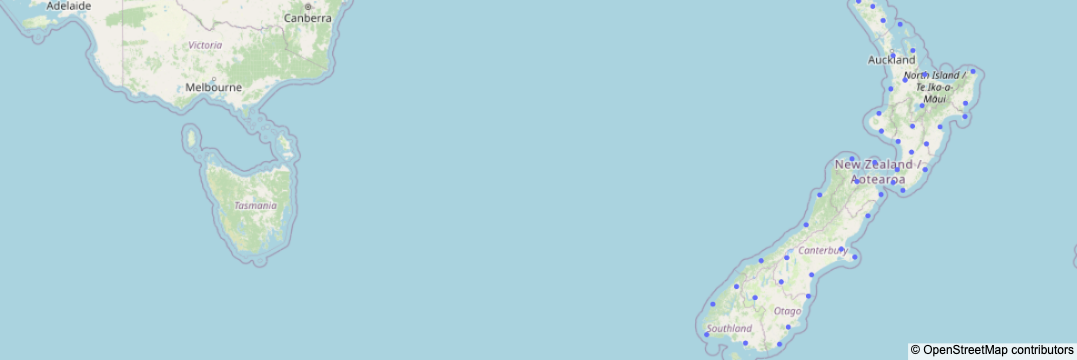

In [5]:
# Centro do mapa (média das coords)
center_lat = df["Latitude"].mean()
center_lon = df["Longitude"].mean()

# Mapa interativo
fig = px.scatter_mapbox(
    df,
    lat="Latitude",
    lon="Longitude",
    hover_name="station_name",
    zoom=4,
    height=650
)
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": center_lat, "lon": center_lon},
    margin={"l":0, "r":0, "t":0, "b":0},
)

# Mostrar na tela
fig.show()

## Definindo arestas

In [6]:
NO_EDGE = np.inf

def osrm_route_distance_km(lat1, lon1, lat2, lon2, profile="driving", base_url="https://router.project-osrm.org"):
    """
    Consulta a API OSRM pública para obter a distância da rota em km.
    Retorna float(km) ou None se não existir rota.
    """
    # OSRM espera ordem: lon,lat;lon,lat
    url = f"{base_url}/route/v1/{profile}/{lon1},{lat1};{lon2},{lat2}"
    params = {
        "overview": "false",
        "alternatives": "false",
        "steps": "false",
        "annotations": "false"
    }
    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        data = r.json()
        if data.get("code") == "Ok" and data.get("routes"):
            dist_m = data["routes"][0]["distance"]
            return dist_m / 1000.0  # km
        return None
    except Exception:
        return None

In [7]:
def build_adjacency_osrm(df, station_col="station_name", lat_col="Latitude", lon_col="Longitude", undirected=True):
    n = len(df)
    idx = list(range(n))
    names = df[station_col].tolist()

    # matriz de adjacência (distância); diagonal = 0
    A = np.full((n, n), NO_EDGE, dtype=float)
    np.fill_diagonal(A, 0.0)

    # cache simples para evitar chamadas repetidas (par sem direção)
    cache = {}

    # itera pares i<j para grafo não-direcionado
    for i, j in combinations(idx, 2):
        lat1, lon1 = df.loc[i, lat_col], df.loc[i, lon_col]
        lat2, lon2 = df.loc[j, lat_col], df.loc[j, lon_col]
        key = tuple(sorted([(lat1, lon1), (lat2, lon2)]))

        if key in cache:
            dist = cache[key]
        else:
            dist = osrm_route_distance_km(lat1, lon1, lat2, lon2)
            cache[key] = dist

        if dist is not None:
            A[i, j] = dist
            if undirected:
                A[j, i] = dist
        else:
            # sem caminho: permanece NO_EDGE (np.inf)
            pass

    return pd.DataFrame(A, index=names, columns=names)

### com OSMNX

In [8]:
O_EDGE = np.inf

def subgraph_between_points(lat1, lon1, lat2, lon2, buffer_m=30000, network_type="drive"):
    """
    Baixa um subgrafo do OSM que cobre os dois pontos + um buffer (em metros).
    Isso reduz tempo/memória versus pegar o país inteiro.
    """
    # bounding box expandida
    north = max(lat1, lat2)
    south = min(lat1, lat2)
    east  = max(lon1, lon2)
    west  = min(lon1, lon2)

    # expande em metros (usa projeções internas do osmnx)
    # truque: pega um centro aproximado e um raio em metros que cubra a caixa + buffer
    center_lat = (lat1 + lat2) / 2
    center_lon = (lon1 + lon2) / 2

    # distância aproximada para cobrir diagonal da caixa (muito simples)
    # usa fórmula grosseira: 1 grau lat ~ 111 km; 1 grau lon ~ 111 km * cos(lat)
    lat_km = (north - south) * 111_000
    lon_km = (east - west) * 111_000 * np.cos(np.radians(center_lat))
    radius_m = int(np.hypot(lat_km, lon_km) / 2 + buffer_m)

    # baixa grafo centrado no meio dos pontos, com raio
    G = ox.graph_from_point((center_lat, center_lon), dist=radius_m, network_type=network_type, simplify=True)
    # adiciona pesos de comprimento em metros (se não existir)
    if "length" not in list(ox.graph_to_gdfs(G, nodes=False, edges=True).columns):
        G = ox.add_edge_lengths(G)

    return G

def osmnx_route_distance_km(G, lat1, lon1, lat2, lon2, weight="length"):
    """
    Calcula a menor rota no grafo com base no atributo 'length' (metros).
    Retorna distância em km ou None se não encontrar caminho.
    """
    try:
        # OSMNX nearest_nodes espera x=lon, y=lat
        orig = ox.distance.nearest_nodes(G, X=lon1, Y=lat1)
        dest = ox.distance.nearest_nodes(G, X=lon2, Y=lat2)

        route = nx.shortest_path(G, orig, dest, weight=weight)
        # soma comprimentos (em metros)
        dist_m = 0.0
        for u, v in zip(route[:-1], route[1:]):
            data = min(G[u][v].values(), key=lambda d: d.get(weight, np.inf))
            dist_m += data.get(weight, 0.0)
        return dist_m / 1000.0
    except Exception:
        return None

def build_adjacency_osmnx(df, station_col="station_name", lat_col="Latitude", lon_col="Longitude", undirected=True, buffer_m=30000):
    n = len(df)
    idx = list(range(n))
    names = df[station_col].tolist()
    A = np.full((n, n), NO_EDGE, dtype=float)
    np.fill_diagonal(A, 0.0)

    # itera pares (i, j)
    for i, j in combinations(idx, 2):
        lat1, lon1 = df.loc[i, lat_col], df.loc[i, lon_col]
        lat2, lon2 = df.loc[j, lat_col], df.loc[j, lon_col]

        # subgrafo mínimo capaz de cobrir o par
        G = subgraph_between_points(lat1, lon1, lat2, lon2, buffer_m=buffer_m, network_type="drive")
        dist = osmnx_route_distance_km(G, lat1, lon1, lat2, lon2)

        if dist is not None:
            A[i, j] = dist
            if undirected:
                A[j, i] = dist
        # caso contrário, permanece np.inf

    return pd.DataFrame(A, index=names, columns=names)

In [9]:
# adj_osmnx = build_adjacency_osmnx(df, buffer_m=30000)
# print(adj_osmnx)

In [10]:
# adj_osmnx

### Com osrm

In [11]:
adj_osrm = build_adjacency_osrm(df)
print(adj_osrm)

                          Le_Bons  Tauranga_Aerodrome  Enderby_Island  \
Le_Bons                    0.0000           1061.1512        701.8487   
Tauranga_Aerodrome      1061.1512              0.0000       1589.9288   
Enderby_Island           701.8487           1589.9288          0.0000   
Cape_Campbell            390.2741            709.3949        918.8231   
Whitianga_Aerodrome     1185.2180            168.5927       1713.7670   
Tara_Hills               391.5745           1279.6546        399.9712   
Napier_Aerodrome         856.9942            284.7898       1385.5431   
Hawera_NZHAX             814.3317            375.1014       1342.8806   
Secretary_Island         784.5451           1672.6252        235.0035   
Queenstown_Aerodrome     546.4084           1434.4885        249.4107   
Christchurch_Aerodrome   101.4297            967.4920        624.0746   
South_West               702.2318           1590.3119          3.1958   
Invercargill_NZNVA       647.2918           1535.37

In [20]:
adj_osrm

,Le_Bons,Tauranga_Aerodrome,Enderby_Island,Cape_Campbell,Whitianga_Aerodrome,Tara_Hills,Napier_Aerodrome,Hawera_NZHAX,Secretary_Island,Queenstown_Aerodrome,Christchurch_Aerodrome,South_West,Invercargill_NZNVA,Palmerston_N,Oamaru_Aerodrome,Kaikoura_NZKIX,Whanganui_Aerodrome,Taupo_Aerodrome,Hokitika_Aerodrome,Nugget_Point,Mokohinau_Island,Ngawi_NZNWX,Mt_Cook,Cape_Reinga,Auckland_Aerodrome,Hamilton_Aerodrome,Wellington_Aerodrome,New_Plymouth,Haast_NZHTX,Stephens_Island,Milford_Sound,Gisborne_Aerodrome,Puysegur_Point,Nelson_Aerodrome,Timaru_Airport,Hicks_Bay,Port_Taharoa,Farewell_Spit,Castlepoint_NZCPX,Chatham_Island,Kerikeri_Aerodrome,Raoul_Island,Dunedin_Aerodrome,Whangarei_Aerodrome,Kaitaia_Aerodrome,Paraparaumu_Aerodrome,Takapau_Plains,Waiouru_Aerodrome,Mahia_NZMHX,Campbell_Island,Westport_Aerodrome
Le_Bons,0.0000,1061.1512,701.8487,390.2741,1185.2180,391.5745,856.9942,814.3317,784.5451,546.4084,101.4297,702.2318,647.2918,682.8032,304.3907,277.3259,726.9220,898.4099,326.1205,549.1643,1310.0815,676.1156,396.3774,1592.3211,1160.4270,1038.6792,542.4131,885.1341,604.7157,568.2029,827.0813,1058.0466,737.6888,508.0738,227.1707,1245.2445,1045.6227,620.1611,698.5104,inf,1411.9619,inf,459.9305,1335.4863,1491.0302,587.3357,752.1183,799.6837,1022.6465,703.0560,424.7472
Tauranga_Aerodrome,1061.1512,0.0000,1589.9288,709.3949,168.5927,1279.6546,284.7898,375.1014,1672.6252,1434.4885,967.4920,1590.3119,1535.3719,394.9784,1192.4708,786.2613,376.3111,153.9144,1015.7791,1437.2444,366.9014,591.2383,1284.4575,649.1409,217.2469,108.6953,535.1104,307.1509,1294.3743,781.3941,1715.1614,266.5410,1625.7689,742.2099,1115.2508,279.3090,204.7113,889.7283,552.5170,inf,468.7818,inf,1348.0106,392.3062,547.8501,479.7730,374.3691,266.5794,352.1075,1591.1361,915.5415
Enderby_Island,701.8487,1589.9288,0.0000,918.8231,1713.7670,399.9712,1385.5431,1342.8806,235.0035,249.4107,624.0746,3.1958,75.8097,1211.3521,400.1578,805.8749,1255.4709,1426.9588,728.7082,212.3119,1838.6304,1204.6645,494.0420,2120.8700,1688.9759,1567.2281,1070.9621,1413.6831,455.2925,1096.7519,341.7410,1586.5955,188.5066,1047.8352,479.7957,1773.7935,1574.1716,1159.9225,1227.0594,inf,1940.5109,inf,246.5075,1864.0353,2019.5792,1115.8846,1280.6672,1328.2326,1551.1954,4.0704,868.8858
Cape_Campbell,390.2741,709.3949,918.8231,0.0000,833.4000,608.7157,505.1761,462.5136,1001.6863,763.5496,296.5531,919.3730,864.4330,330.9851,521.5319,115.3225,375.1039,546.5918,418.2942,766.3055,958.2634,324.2975,613.5186,1240.5030,808.6089,686.8611,190.5951,533.3161,696.8894,216.3849,1044.2225,706.2285,954.8301,177.2007,444.3119,893.4265,693.8046,324.7191,346.6924,inf,1060.1439,inf,677.0717,983.6683,1139.2122,235.5176,400.3002,447.8656,670.8284,920.1972,318.0567
Whitianga_Aerodrome,1185.2180,168.5927,1713.7670,833.4000,0.0000,1403.6258,417.9044,462.4461,1796.5964,1558.4597,1091.4632,1714.2831,1659.3431,518.9496,1316.4420,910.2325,500.2823,287.0290,1139.7503,1561.2156,324.4265,715.2095,1408.4287,606.6661,174.7720,180.8503,659.0816,394.4956,1418.3455,905.3653,1839.1326,433.7389,1749.7401,866.1812,1239.2220,446.5068,283.4097,1013.6995,676.4882,inf,426.3069,inf,1471.9818,349.8313,505.3752,603.7442,507.4837,390.5506,519.3054,1715.1073,1039.5127
Tara_Hills,391.5745,1279.6546,399.9712,608.7157,1403.6258,0.0000,1075.2781,1032.6156,396.3578,158.2211,313.8095,400.4009,342.9842,901.0871,126.4169,495.6098,945.2059,1116.6938,471.9514,310.5090,1528.3654,894.3994,97.4580,1810.6049,1378.7109,1256.9631,760.6970,1103.4180,243.0456,786.4868,438.8940,1276.3305,387.7228,727.4247,179.8785,1463.5284,1263.9065,839.5120,916.7943,inf,1630.2458,inf,266.5644,1553.7702,1709.3141,805.6196,970.4022,1017.9676,1240.9304,401.2251,570.5781
Napier_Aerodrome,856.9942,284.7898,1385.5431,505.1761,417.9044,1075.2781,0.0000,347.8593,1472.6560,1234.5193,767.5228,1390.3426,1335.4026,191.0159,992.5016,586.2921,260.4496,139.7051,815.8098,1237.2752,543.2548,343.9540,1084.4883,825.4944,393.6003,285.0487,335.1412,413.2262,1094.4050,581.4249,1515.1921,211.2277,1425.7997,54

In [13]:
adj_osrm.head()

,Le_Bons,Tauranga_Aerodrome,Enderby_Island,Cape_Campbell,Whitianga_Aerodrome,Tara_Hills,Napier_Aerodrome,Hawera_NZHAX,Secretary_Island,Queenstown_Aerodrome,Christchurch_Aerodrome,South_West,Invercargill_NZNVA,Palmerston_N,Oamaru_Aerodrome,Kaikoura_NZKIX,Whanganui_Aerodrome,Taupo_Aerodrome,Hokitika_Aerodrome,Nugget_Point,Mokohinau_Island,Ngawi_NZNWX,Mt_Cook,Cape_Reinga,Auckland_Aerodrome,Hamilton_Aerodrome,Wellington_Aerodrome,New_Plymouth,Haast_NZHTX,Stephens_Island,Milford_Sound,Gisborne_Aerodrome,Puysegur_Point,Nelson_Aerodrome,Timaru_Airport,Hicks_Bay,Port_Taharoa,Farewell_Spit,Castlepoint_NZCPX,Chatham_Island,Kerikeri_Aerodrome,Raoul_Island,Dunedin_Aerodrome,Whangarei_Aerodrome,Kaitaia_Aerodrome,Paraparaumu_Aerodrome,Takapau_Plains,Waiouru_Aerodrome,Mahia_NZMHX,Campbell_Island,Westport_Aerodrome
Le_Bons,0.0000,1061.1512,701.8487,390.2741,1185.2180,391.5745,856.9942,814.3317,784.5451,546.4084,101.4297,702.2318,647.2918,682.8032,304.3907,277.3259,726.9220,898.4099,326.1205,549.1643,1310.0815,676.1156,396.3774,1592.3211,1160.4270,1038.6792,542.4131,885.1341,604.7157,568.2029,827.0813,1058.0466,737.6888,508.0738,227.1707,1245.2445,1045.6227,620.1611,698.5104,inf,1411.9619,inf,459.9305,1335.4863,1491.0302,587.3357,752.1183,799.6837,1022.6465,703.0560,424.7472
Tauranga_Aerodrome,1061.1512,0.0000,1589.9288,709.3949,168.5927,1279.6546,284.7898,375.1014,1672.6252,1434.4885,967.4920,1590.3119,1535.3719,394.9784,1192.4708,786.2613,376.3111,153.9144,1015.7791,1437.2444,366.9014,591.2383,1284.4575,649.1409,217.2469,108.6953,535.1104,307.1509,1294.3743,781.3941,1715.1614,266.5410,1625.7689,742.2099,1115.2508,279.3090,204.7113,889.7283,552.5170,inf,468.7818,inf,1348.0106,392.3062,547.8501,479.7730,374.3691,266.5794,352.1075,1591.1361,915.5415
Enderby_Island,701.8487,1589.9288,0.0000,918.8231,1713.7670,399.9712,1385.5431,1342.8806,235.0035,249.4107,624.0746,3.1958,75.8097,1211.3521,400.1578,805.8749,1255.4709,1426.9588,728.7082,212.3119,1838.6304,1204.6645,494.0420,2120.8700,1688.9759,1567.2281,1070.9621,1413.6831,455.2925,1096.7519,341.7410,1586.5955,188.5066,1047.8352,479.7957,1773.7935,1574.1716,1159.9225,1227.0594,inf,1940.5109,inf,246.5075,1864.0353,2019.5792,1115.8846,1280.6672,1328.2326,1551.1954,4.0704,868.8858
Cape_Campbell,390.2741,709.3949,918.8231,0.0000,833.4000,608.7157,505.1761,462.5136,1001.6863,763.5496,296.5531,919.3730,864.4330,330.9851,521.5319,115.3225,375.1039,546.5918,418.2942,766.3055,958.2634,324.2975,613.5186,1240.5030,808.6089,686.8611,190.5951,533.3161,696.8894,216.3849,1044.2225,706.2285,954.8301,177.2007,444.3119,893.4265,693.8046,324.7191,346.6924,inf,1060.1439,inf,677.0717,983.6683,1139.2122,235.5176,400.3002,447.8656,670.8284,920.1972,318.0567
Whitianga_Aerodrome,1185.2180,168.5927,1713.7670,833.4000,0.0000,1403.6258,417.9044,462.4461,1796.5964,1558.4597,1091.4632,1714.2831,1659.3431,518.9496,1316.4420,910.2325,500.2823,287.0290,1139.7503,1561.2156,324.4265,715.2095,1408.4287,606.6661,174.7720,180.8503,659.0816,394.4956,1418.3455,905.3653,1839.1326,433.7389,1749.7401,866.1812,1239.2220,446.5068,283.4097,1013.6995,676.4882,inf,426.3069,inf,1471.9818,349.8313,505.3752,603.7442,507.4837,390.5506,519.3054,1715.1073,1039.5127


In [27]:
adj_osrm.to_csv('matriz_adjacencia.csv', index=True)

In [24]:
adj_osrm.columns

Index(['Le_Bons', 'Tauranga_Aerodrome', 'Enderby_Island', 'Cape_Campbell',
       'Whitianga_Aerodrome', 'Tara_Hills', 'Napier_Aerodrome', 'Hawera_NZHAX',
       'Secretary_Island', 'Queenstown_Aerodrome', 'Christchurch_Aerodrome',
       'South_West', 'Invercargill_NZNVA', 'Palmerston_N', 'Oamaru_Aerodrome',
       'Kaikoura_NZKIX', 'Whanganui_Aerodrome', 'Taupo_Aerodrome',
       'Hokitika_Aerodrome', 'Nugget_Point', 'Mokohinau_Island', 'Ngawi_NZNWX',
       'Mt_Cook', 'Cape_Reinga', 'Auckland_Aerodrome', 'Hamilton_Aerodrome',
       'Wellington_Aerodrome', 'New_Plymouth', 'Haast_NZHTX',
       'Stephens_Island', 'Milford_Sound', 'Gisborne_Aerodrome',
       'Puysegur_Point', 'Nelson_Aerodrome', 'Timaru_Airport', 'Hicks_Bay',
       'Port_Taharoa', 'Farewell_Spit', 'Castlepoint_NZCPX', 'Chatham_Island',
       'Kerikeri_Aerodrome', 'Raoul_Island', 'Dunedin_Aerodrome',
       'Whangarei_Aerodrome', 'Kaitaia_Aerodrome', 'Paraparaumu_Aerodrome',
       'Takapau_Plains', 'Waiouru_Aerodro

In [26]:
adj_osrm.iloc[6]

Le_Bons                    856.9942
Tauranga_Aerodrome         284.7898
Enderby_Island            1385.5431
Cape_Campbell              505.1761
Whitianga_Aerodrome        417.9044
Tara_Hills                1075.2781
Napier_Aerodrome             0.0000
Hawera_NZHAX               347.8593
Secretary_Island          1472.6560
Queenstown_Aerodrome      1234.5193
Christchurch_Aerodrome     767.5228
South_West                1390.3426
Invercargill_NZNVA        1335.4026
Palmerston_N               191.0159
Oamaru_Aerodrome           992.5016
Kaikoura_NZKIX             586.2921
Whanganui_Aerodrome        260.4496
Taupo_Aerodrome            139.7051
Hokitika_Aerodrome         815.8098
Nugget_Point              1237.2752
Mokohinau_Island           543.2548
Ngawi_NZNWX                343.9540
Mt_Cook                   1084.4883
Cape_Reinga                825.4944
Auckland_Aerodrome         393.6003
Hamilton_Aerodrome         285.0487
Wellington_Aerodrome       335.1412
New_Plymouth               4

In [14]:
adj_osrm.to_csv("adj_osrm.csv", index=False)
adj_osrm.to_parquet("adj_osrm.parquet", index=False)

In [15]:
import numpy as np
import pandas as pd
import networkx as nx

# --- Pré-requisito: adj_osrm é um DataFrame NxN (distâncias em km).
# Índice e colunas devem ter a MESMA ordem e os mesmos rótulos (ex.: station_name).
# Example: adj_osrm.loc[adj_osrm.index, adj_osrm.index]  # garante alinhamento

def save_graph_from_adj(
    adj_df: pd.DataFrame,
    nodes_df: pd.DataFrame | None = None,  # opcional: df com atributos dos nós
    name_col: str = "station_name",
    lat_col: str = "Latitude",
    lon_col: str = "Longitude",
    filename_col: str = "Filename",
    directed: bool = False,
    symmetrize: str = "min",  # "min"|"mean"|"max"|None (para grafos não-dirigidos)
    adj_csv_path: str = "adjacency_osrm.csv",
    gexf_path: str = "rede_osrm.gexf",
    graphml_path: str = "rede_osrm.graphml",
    edgelist_path: str = "edges_osrm.csv",
):
    # 1) Sanitiza e garante alinhamento índice = colunas
    A = adj_df.copy()
    # converte strings "inf"/"nan" etc.
    A = A.replace([np.inf, "inf", "Inf", "INF"], np.inf).apply(pd.to_numeric, errors="coerce")
    # garante que as colunas sigam a ordem do índice (e existam)
    A = A.loc[A.index, A.index]
    # zera diagonal
    np.fill_diagonal(A.values, 0.0)

    # 2) Se grafo não-direcionado e a matriz não for perfeitamente simétrica, opcionalmente simetriza
    if not directed and symmetrize:
        if symmetrize == "min":
            A = pd.DataFrame(np.minimum(A.values, A.values.T), index=A.index, columns=A.columns)
        elif symmetrize == "mean":
            A = (A + A.T) / 2
        elif symmetrize == "max":
            A = pd.DataFrame(np.maximum(A.values, A.values.T), index=A.index, columns=A.columns)

    # 3) Cria grafo
    G = nx.DiGraph() if directed else nx.Graph()
    nodes = A.index.tolist()
    G.add_nodes_from(nodes)

    # 4) Atributos dos nós (opcional)
    if nodes_df is not None:
        meta = nodes_df.set_index(name_col)
        attrs = {}
        for n in nodes:
            if n in meta.index:
                attr = {}
                if lat_col in meta.columns:  attr["Latitude"]  = float(meta.at[n, lat_col])
                if lon_col in meta.columns:  attr["Longitude"] = float(meta.at[n, lon_col])
                if filename_col in meta.columns: attr["Filename"] = meta.at[n, filename_col]
                if attr:
                    attrs[n] = attr
        if attrs:
            nx.set_node_attributes(G, attrs)

    # 5) Adiciona arestas (peso = distância km)
    if directed:
        # adiciona todas as arestas u->v com distância finita e > 0
        for u in nodes:
            for v, d in A.loc[u].items():
                if u != v and np.isfinite(d) and d > 0:
                    G.add_edge(u, v, weight=float(d))
    else:
        # não-direcionado: só metade superior para não duplicar
        for i, u in enumerate(nodes):
            for j in range(i + 1, len(nodes)):
                v = nodes[j]
                d = float(A.iat[i, j])
                if np.isfinite(d) and d > 0:
                    G.add_edge(u, v, weight=d)

    # 6) Salva matriz de adjacência alinhada ao nodelist (np.inf para não-arestas)
    A_out = nx.to_numpy_array(G, nodelist=nodes, weight="weight", nonedge=np.inf)
    pd.DataFrame(A_out, index=nodes, columns=nodes).to_csv(adj_csv_path, index=True)

    # 7) Salva o grafo
    nx.write_gexf(G, gexf_path)       # bom pro Gephi
    nx.write_graphml(G, graphml_path) # interoperável com QGIS/Gephi/Neo4j tools

    # 8) Edgelist (u, v, weight) para inspeção rápida
    edges_df = nx.to_pandas_edgelist(G)
    # renomeia coluna de peso (de 'weight' para 'distance_km' por clareza)
    if "weight" in edges_df.columns:
        edges_df = edges_df.rename(columns={"weight": "distance_km"})
    edges_df.to_csv(edgelist_path, index=False)

    # resumo rápido
    print(f"Nos: {G.number_of_nodes()} | Arestas: {G.number_of_edges()}")
    return G

In [16]:
 G = save_graph_from_adj(adj_osrm, nodes_df=df)

Nos: 51 | Arestas: 1177


In [17]:
G

In [18]:
nx.write_graphml(G, "grafo.graphml")

In [23]:
adj_osrm.columns

Index(['Le_Bons', 'Tauranga_Aerodrome', 'Enderby_Island', 'Cape_Campbell',
       'Whitianga_Aerodrome', 'Tara_Hills', 'Napier_Aerodrome', 'Hawera_NZHAX',
       'Secretary_Island', 'Queenstown_Aerodrome', 'Christchurch_Aerodrome',
       'South_West', 'Invercargill_NZNVA', 'Palmerston_N', 'Oamaru_Aerodrome',
       'Kaikoura_NZKIX', 'Whanganui_Aerodrome', 'Taupo_Aerodrome',
       'Hokitika_Aerodrome', 'Nugget_Point', 'Mokohinau_Island', 'Ngawi_NZNWX',
       'Mt_Cook', 'Cape_Reinga', 'Auckland_Aerodrome', 'Hamilton_Aerodrome',
       'Wellington_Aerodrome', 'New_Plymouth', 'Haast_NZHTX',
       'Stephens_Island', 'Milford_Sound', 'Gisborne_Aerodrome',
       'Puysegur_Point', 'Nelson_Aerodrome', 'Timaru_Airport', 'Hicks_Bay',
       'Port_Taharoa', 'Farewell_Spit', 'Castlepoint_NZCPX', 'Chatham_Island',
       'Kerikeri_Aerodrome', 'Raoul_Island', 'Dunedin_Aerodrome',
       'Whangarei_Aerodrome', 'Kaitaia_Aerodrome', 'Paraparaumu_Aerodrome',
       'Takapau_Plains', 'Waiouru_Aerodro

In [28]:
G.nodes

NodeView(('Le_Bons', 'Tauranga_Aerodrome', 'Enderby_Island', 'Cape_Campbell', 'Whitianga_Aerodrome', 'Tara_Hills', 'Napier_Aerodrome', 'Hawera_NZHAX', 'Secretary_Island', 'Queenstown_Aerodrome', 'Christchurch_Aerodrome', 'South_West', 'Invercargill_NZNVA', 'Palmerston_N', 'Oamaru_Aerodrome', 'Kaikoura_NZKIX', 'Whanganui_Aerodrome', 'Taupo_Aerodrome', 'Hokitika_Aerodrome', 'Nugget_Point', 'Mokohinau_Island', 'Ngawi_NZNWX', 'Mt_Cook', 'Cape_Reinga', 'Auckland_Aerodrome', 'Hamilton_Aerodrome', 'Wellington_Aerodrome', 'New_Plymouth', 'Haast_NZHTX', 'Stephens_Island', 'Milford_Sound', 'Gisborne_Aerodrome', 'Puysegur_Point', 'Nelson_Aerodrome', 'Timaru_Airport', 'Hicks_Bay', 'Port_Taharoa', 'Farewell_Spit', 'Castlepoint_NZCPX', 'Chatham_Island', 'Kerikeri_Aerodrome', 'Raoul_Island', 'Dunedin_Aerodrome', 'Whangarei_Aerodrome', 'Kaitaia_Aerodrome', 'Paraparaumu_Aerodrome', 'Takapau_Plains', 'Waiouru_Aerodrome', 'Mahia_NZMHX', 'Campbell_Island', 'Westport_Aerodrome'))